This notebook peforms a blind tip reconstruction using the gradient decent of the opening from noise-free image data

## load required packages and test data

In [1]:
using Flux
using Flux.Data: DataLoader
using Plots
using BSON: @save, @load
using Statistics
using Revise, MDToolbox

In [2]:
@load "prepare_test_data.bson" width height resolution radius angle param models tip nx ny surfs images images_randn

## Define Flux layers

In [3]:
struct IOpen
    P::AbstractArray
end

IOpen(height::Integer, width::Integer) = IOpen(zeros(Float64, height, width))

Flux.@functor IOpen (P,)

(m::IOpen)(image) = idilation(ierosion(image, m.P), m.P)

## loop over lambda

In [4]:
nframe = 20

images_randn_copy = deepcopy(images)

#lambdas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
lambdas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01]
loss_over_lambdas = []
P_over_lambdas = []

for lambda in lambdas
    @info lambda

    m = IOpen(ny, nx)

    #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( -m.P .* log.(-m.P .+ eps(Float32)))
    #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( - m.P )
    loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn))

    ps = Flux.params(m)

    train_loader = Flux.Data.DataLoader((data=images_randn_copy[1:nframe], label=images_randn[1:nframe]), batchsize=1, shuffle=false);

    #opt = ADAM(0.1)
    opt = ADAMW(1.0, (0.9, 0.999), lambda)
    
    loss_train = []

    for epoch in 1:1000
        for (x, y) in train_loader
            gs = gradient(() -> loss(x, y), ps)
            Flux.Optimise.update!(opt, ps, gs)
            m.P .= min.(m.P, 0.0)
            m.P .= MDToolbox.translate_tip_mean(m.P)
        end
        push!(loss_train, loss(images_randn_copy[1:20], images_randn[1:20]))
    end

    push!(loss_over_lambdas, loss_train[end])
    push!(P_over_lambdas, m.P)
end

┌ Info: 1.0e-7
└ @ Main In[4]:11
┌ Info: 1.0e-6
└ @ Main In[4]:11
┌ Info: 1.0e-5
└ @ Main In[4]:11
┌ Info: 0.0001
└ @ Main In[4]:11
┌ Info: 0.001
└ @ Main In[4]:11
┌ Info: 0.01
└ @ Main In[4]:11


In [5]:
loss_over_lambdas

6-element Vector{Any}:
   9.223079895887162
   9.220293827424971
   9.225180849639449
   9.224167839185588
  12.996241760912076
 124.58046751407342

In [6]:
gr()

Plots.GRBackend()

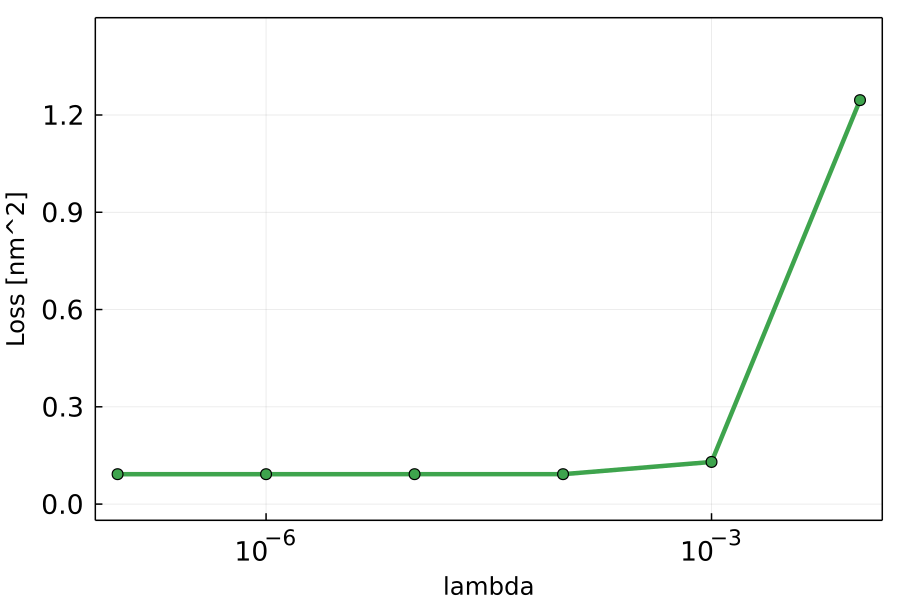

In [7]:
p = plot(lambdas, loss_over_lambdas / 100.0, xaxis=:log, framestyle = :box, 
         xlabel="lambda λ", ylabel="loss [nm^2]", fontsize=35, label=nothing, linewidth=3.0, markershape=:circle, dpi=150, fmt=:png, color=3,
         xtickfontsize=12, ytickfontsize=12, legendfontsize=12)

ylims!(-0.05, 1.5)
xlabel!("lambda", fontsize=35)
p = ylabel!("Loss [nm^2]", fontsize=35)

In [8]:
savefig(p, "blindtip_opening01.png")

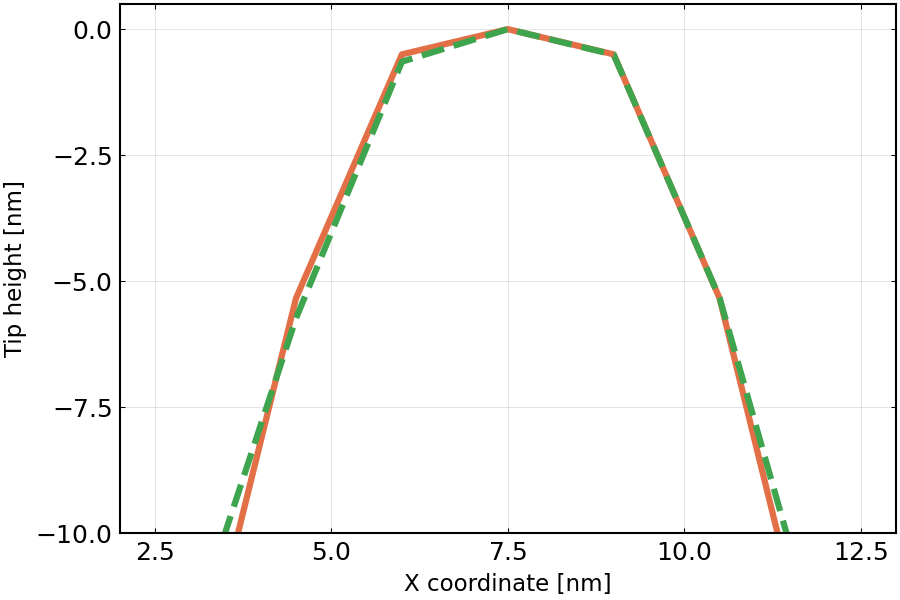

In [27]:
it = 1
islice = 5

plot(collect(1:nx) .* resolution / 10.0, tip[islice, :] / 10.0, linewidth=3, label="ground truth", color=2, 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12)
p = plot!(collect(1:nx) .* resolution / 10.0, P_over_lambdas[it][islice, :] / 10.0, 
    linewidth=3, color=3, linestyle=:dash, label="reconstruction", framestyle=:box, dpi=150, fmt=:png, legend=nothing)

ylims!((-10, 0.5))
xlims!((2, 13))
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Tip height [nm]", fontsize=35)

In [10]:
savefig(p, "blindtip_opening02.png")

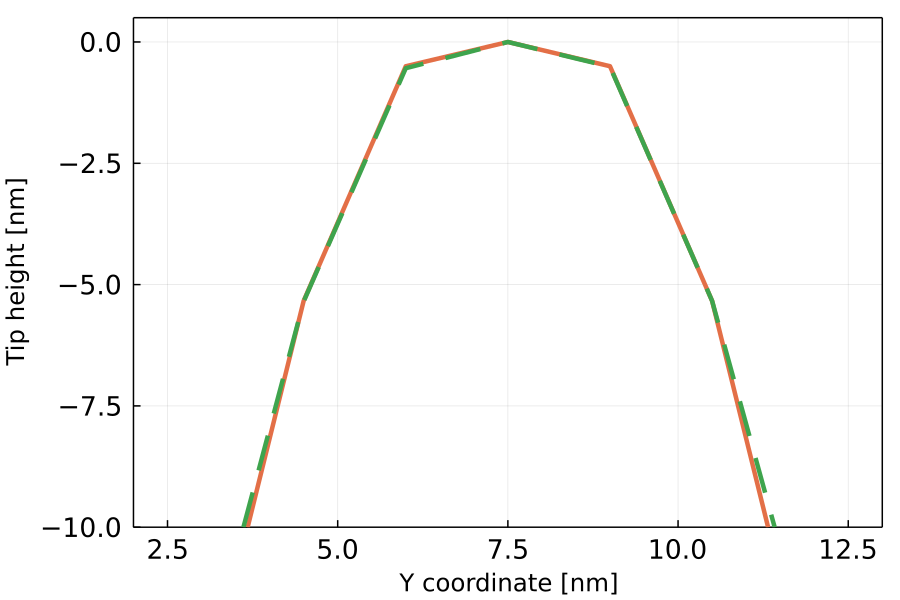

In [11]:
it = 1
islice = 5

plot(collect(1:ny) .* resolution / 10.0, tip[:, islice] / 10.0, linewidth=3, label="ground truth", color=2, 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12)
plot!(collect(1:ny) .* resolution / 10.0, P_over_lambdas[it][:, islice] / 10.0, 
      linewidth=3, color=3, linestyle=:dash, label="reconstruction", 
      framestyle=:box, dpi=150, fmt=:png, legend=nothing)

ylims!((-10, 0.5))
xlims!((2, 13))
xlabel!("Y coordinate [nm]", fontsize=35)
ylabel!("Tip height [nm]", fontsize=35)

In [12]:
savefig(p, "blindtip_opening03.png")

In [13]:
pyplot()

Plots.PyPlotBackend()

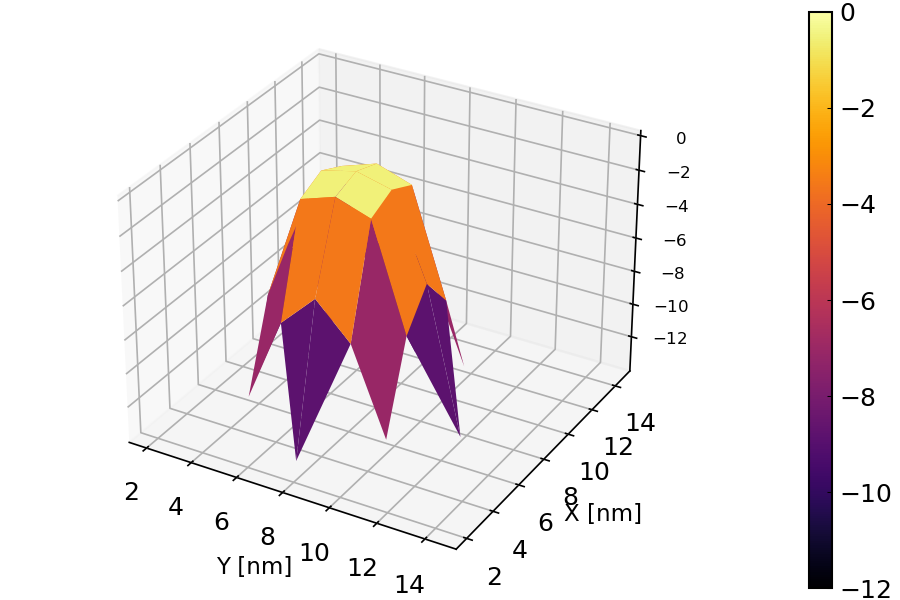

In [14]:
tip_tmp = deepcopy(tip)
tip_tmp[tip .< -150.0] .= NaN

plot(collect(1:nx) .* resolution ./ 10.0, collect(1:ny) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clim=(-12, 0), 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("Y [nm]", fontsize=35)
p = ylabel!("X [nm]", fontsize=35)
#zlabel!("Z [nm]", fontsize=35)
#zlims!((-8, 0.5))
#zlabel!("Tip height [nm]", fontsize=35)

In [15]:
savefig(p, "blindtip_opening04.png")

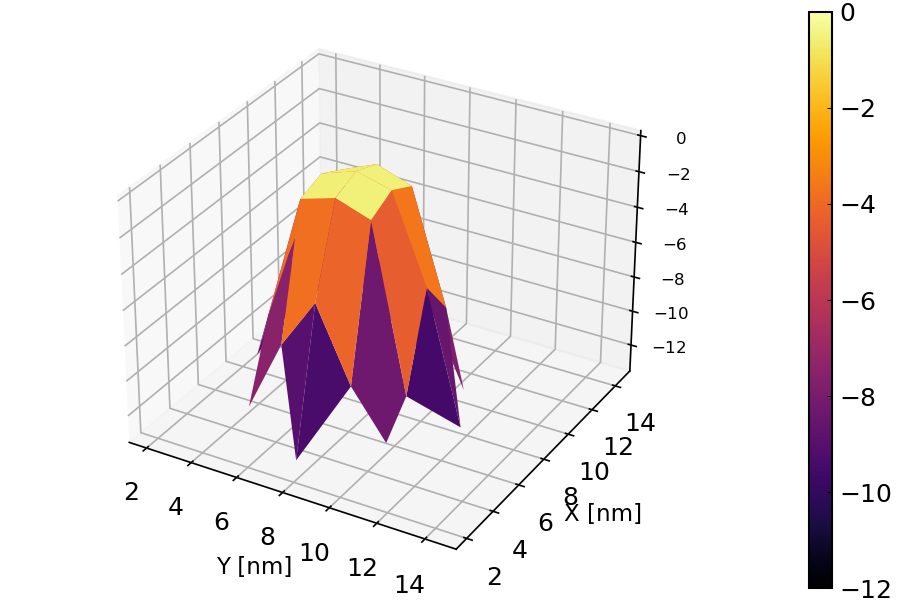

In [16]:
it = 1
tip_tmp = deepcopy(P_over_lambdas[it])
tip_tmp[tip .< -150.0] .= NaN

plot(collect(1:nx) .* resolution ./ 10.0, collect(1:ny) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clim=(-12, 0),
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("Y [nm]", fontsize=35)
p = ylabel!("X [nm]", fontsize=35)
#zlabel!("Z [nm]", fontsize=35)
#zlims!((-8, 0.5))
#zlabel!("Tip height [nm]", fontsize=35)

In [17]:
savefig(p, "blindtip_opening05.png")

In [18]:
gr()

Plots.GRBackend()

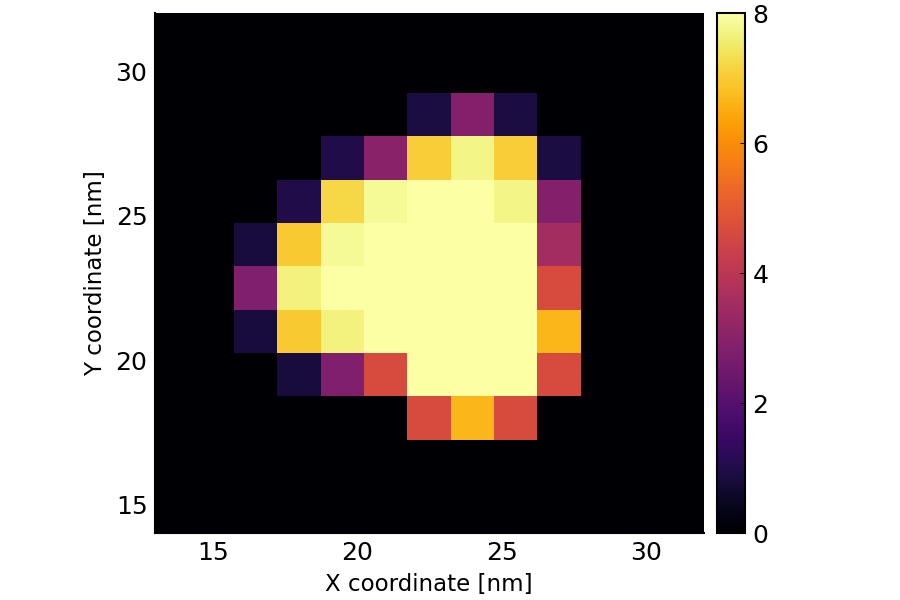

In [21]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, images[1] / 10.0, clim=(0, 8), dpi=150, fmt=:png,
            aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(13, 32)
ylims!(14, 32)

In [22]:
savefig(p, "blindtip_opening06.png")

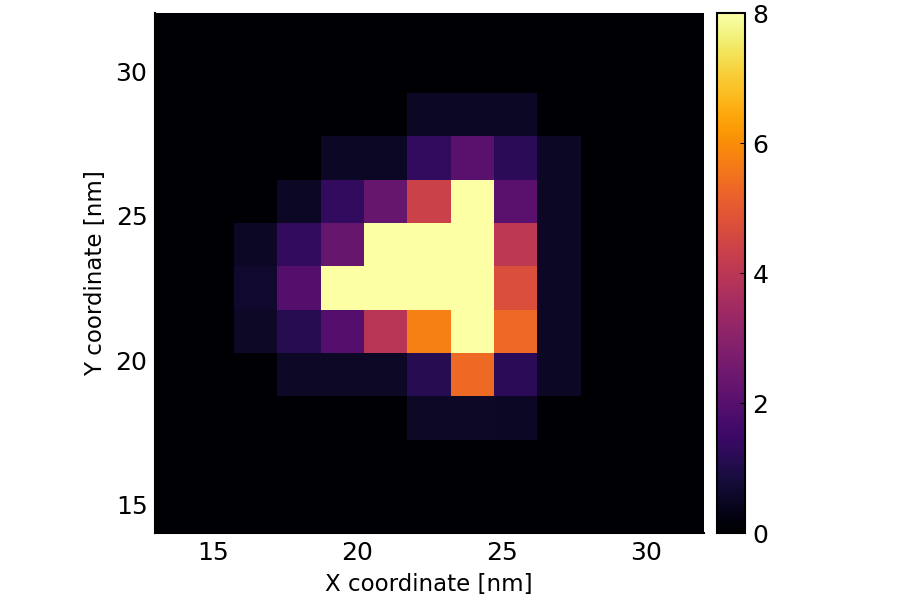

In [23]:
it = 1
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, ierosion(images[1], P_over_lambdas[it]) / 10.0, clim=(0, 8), dpi=150, fmt=:png,
            aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(13, 32)
ylims!(14, 32)

In [24]:
savefig(p, "blindtip_opening07.png")

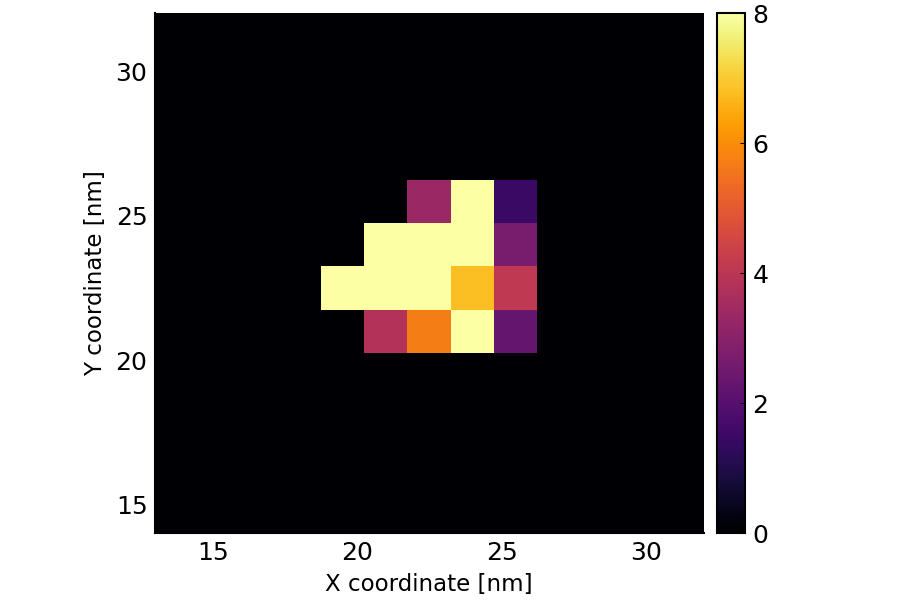

In [25]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, surfs[1] / 10.0, clim=(0, 8), dpi=150, fmt=:png, aspect_ratio=:equal, 
            xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(13, 32)
ylims!(14, 32)

In [26]:
savefig(p, "blindtip_opening08.png")

# Pixel RMSD of reconstructed tip

In [13]:
function pixel_rmsd(image1, image2, ref; cutoff = -70.0)
    image1_shifted = similar(image1)

    rmsd_min = Inf64
    for du = -5:5, dv = -5:5
        image1_shifted = circshift(image1, (du, dv))
        #id = (image1_shifted .> cutoff) .| (image2 .> cutoff)
        id = ref .> cutoff
        tmp = sqrt(mean((image1_shifted[id] .- image2[id]).^2))
        if tmp < rmsd_min
            rmsd_min = tmp
        end
    end
    return rmsd_min
end

diff_tip = zeros(Float64, length(lambdas), 2)
count = 0
for it = 1:length(lambdas)
    c = pixel_rmsd(P_over_lambdas[it], tip, tip)
    count += 1
    diff_tip[count, 1] = lambdas[it]
    diff_tip[count, 2] = c
end

In [ ]:
gr()

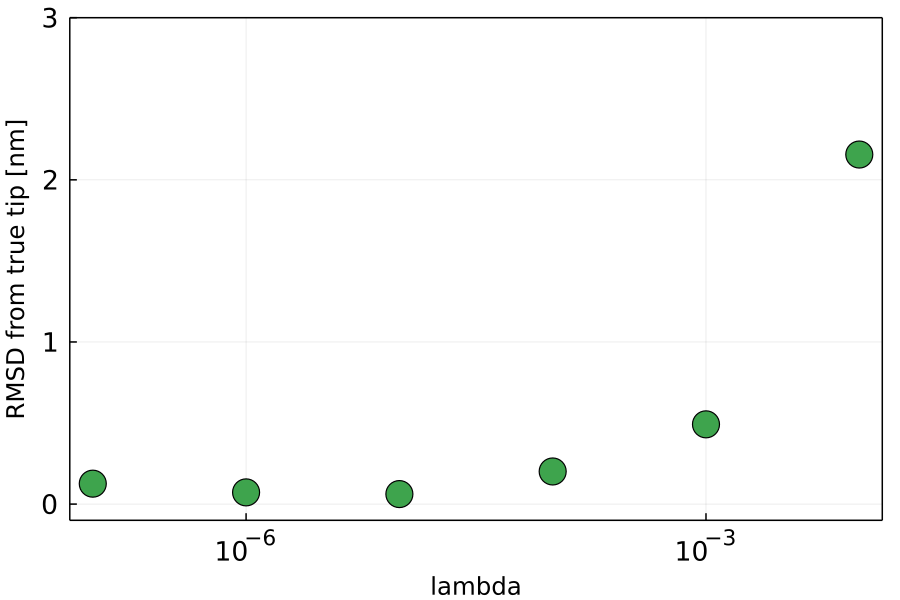

In [14]:
scatter(diff_tip[:, 1], diff_tip[:, 2] / 10.0, xaxis=:log, framestyle = :box, 
        xlabel="threshold T", ylabel="RMSD frome true tip [nm]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=3, 
        xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12, markersize=10, markerstrokewidth=1)
#ylims!(-0.05, 2.3)
xlabel!("lambda", fontsize=35)
p = ylabel!("RMSD from true tip [nm]", fontsize=35)
ylims!(-0.1, 3)

# Pixel RMSD of reconstructed surface

In [15]:
diff_surf = zeros(Float64, length(lambdas)*nframe, 2)
count = 0

for it = 1:length(lambdas)
    for iframe = 1:nframe
        c = pixel_rmsd(ierosion(images[iframe], P_over_lambdas[it]), surfs[iframe], images[iframe])
        count += 1
        diff_surf[count, 1] = lambdas[it]
        diff_surf[count, 2] = c
    end
end

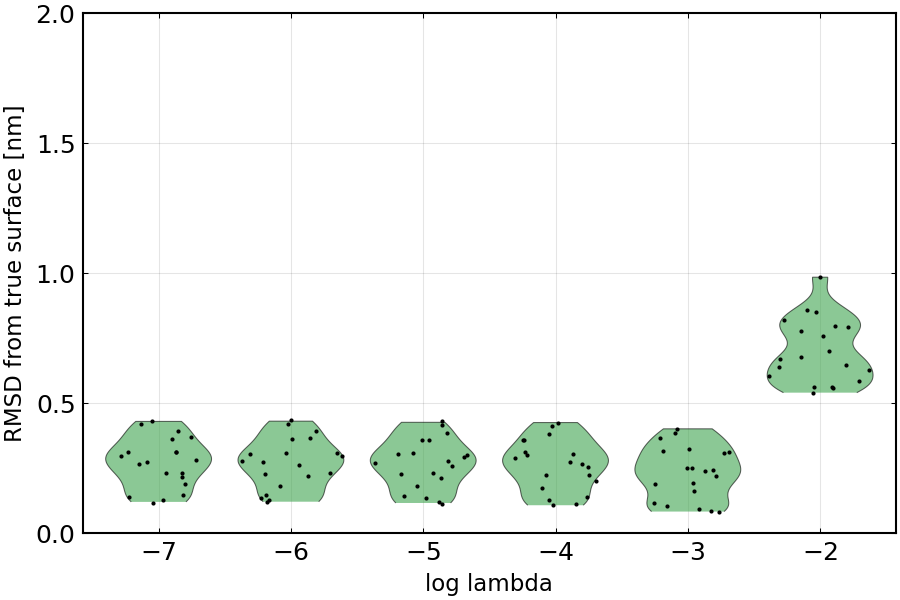

In [16]:
using StatsPlots
pyplot()

violin(log10.(diff_surf[:, 1]), diff_surf[:, 2] / 10.0, ylim=(-0.1, 4.5),
       xtickfontsize=12, ytickfontsize=12, legendfontsize=12, 
       xlabel="log lambda", ylabel="RMSD from true surface [nm]", 
       framestyle=:box, label=nothing, linewidth=0.5, dpi=150, fmt=:png, alpha=0.6, color=3)

dotplot!(log10.(diff_surf[:, 1]), diff_surf[:, 2] / 10.0, marker=(:black, stroke(0)), markersize=2.0, mode = :density, label=nothing)

ylims!(-0.0, 2)

# Save results

In [17]:
using BSON: @save, @load

@save "blindtip_opening.bson" tip images nframe lambdas P_over_lambdas diff_tip diff_surf 